# TRAINING ANALYSIS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax

from glob import glob
from os.path import join

import cloudpickle
import lbc.data as d

In [2]:
BASE_DIR = '/scratch/ch4407/lbc/checkpoints'

experiments = dict()
for latent in [128, 64, 48, 32, 24, 16, 12, 8]:
    with open(join(BASE_DIR, f'h4_l{latent:03d}', 'checkpoint_50000.pkl'), 'rb') as f:
        model, _, _, history = cloudpickle.load(f)
    experiments[latent] = {
        'model': model,
        'history': history
    }

### Training performance

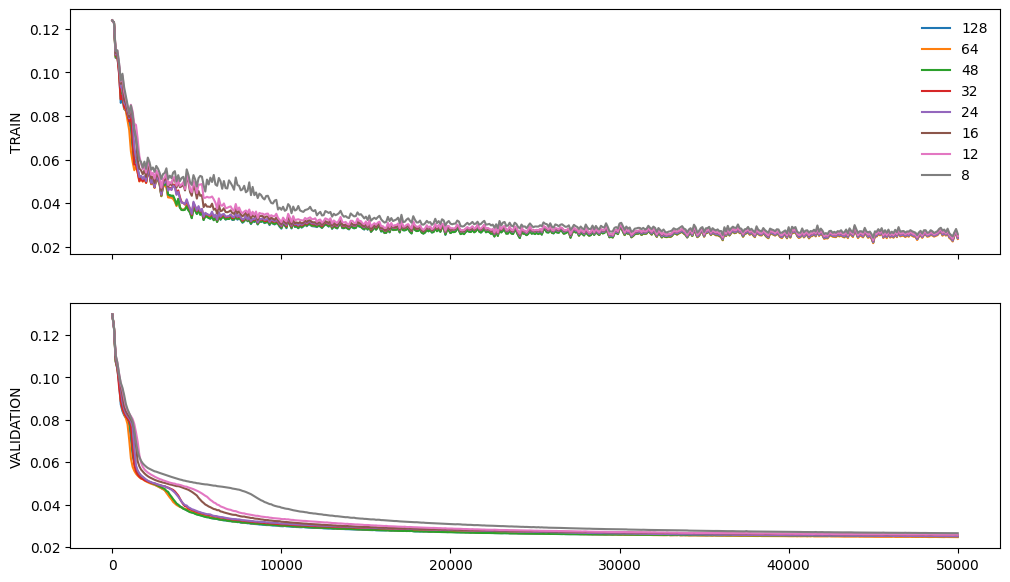

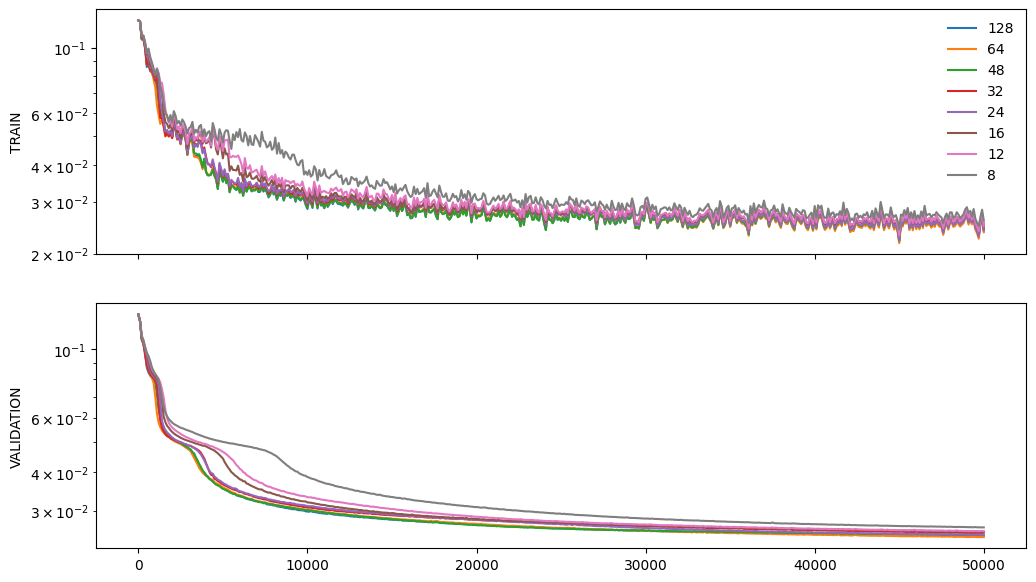

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

for latent, exp in experiments.items():
    history = exp['history']

    axs[0].plot(history['epoch'], history['loss'], label=latent)
    axs[1].plot(history['epoch'], history['loss_val'], label=latent)
    
axs[0].set_ylabel('TRAIN')
axs[1].set_ylabel('VALIDATION')
axs[0].legend(loc='upper right', frameon=False)

plt.show()


fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

for latent, exp in experiments.items():
    history = exp['history']

    axs[0].plot(history['epoch'], history['loss'], label=latent)
    axs[1].plot(history['epoch'], history['loss_val'], label=latent)
    
axs[0].set_ylabel('TRAIN')
axs[1].set_ylabel('VALIDATION')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].legend(loc='upper right', frameon=False)

plt.show()

### held out data

In [4]:
_, _, te = d.split(d.load())
print(te.shape)

Loading images: 100%|██████████| 1774/1774 [00:00<00:00, 4987.32it/s]


(177, 1, 128, 128)


In [5]:
te = jax.numpy.array(te)

def reco_loss(model, x):
    x_hat = jax.vmap(model)(x)
    mse = ((x_hat - x)**2).mean()
    return mse

def single_image_loss(x_hat, x):
    mse = ((x_hat - x) ** 2).mean()
    return mse

In [6]:
latents = list(experiments.keys())
losses = [reco_loss(exp['model'], te) for exp in experiments.values()]

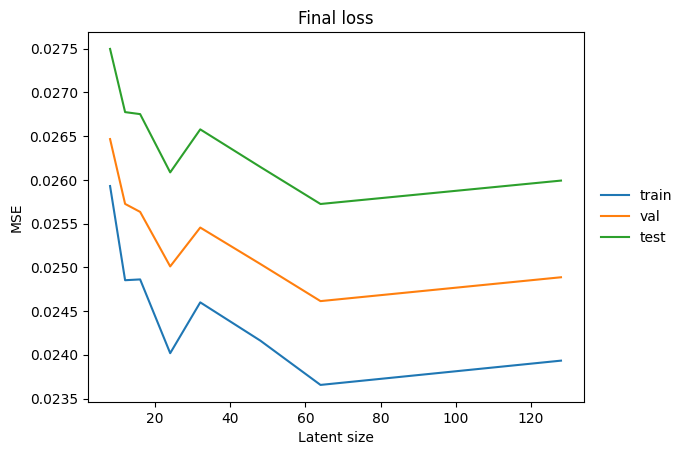

In [7]:
plt.plot(latents, [exp['history']['loss'][-1] for exp in experiments.values()], label='train')
plt.plot(latents, [exp['history']['loss_val'][-1] for exp in experiments.values()], label='val')
plt.plot(latents, losses, label='test')
plt.xlabel('Latent size')
plt.ylabel('MSE')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.title('Final loss')
plt.show()

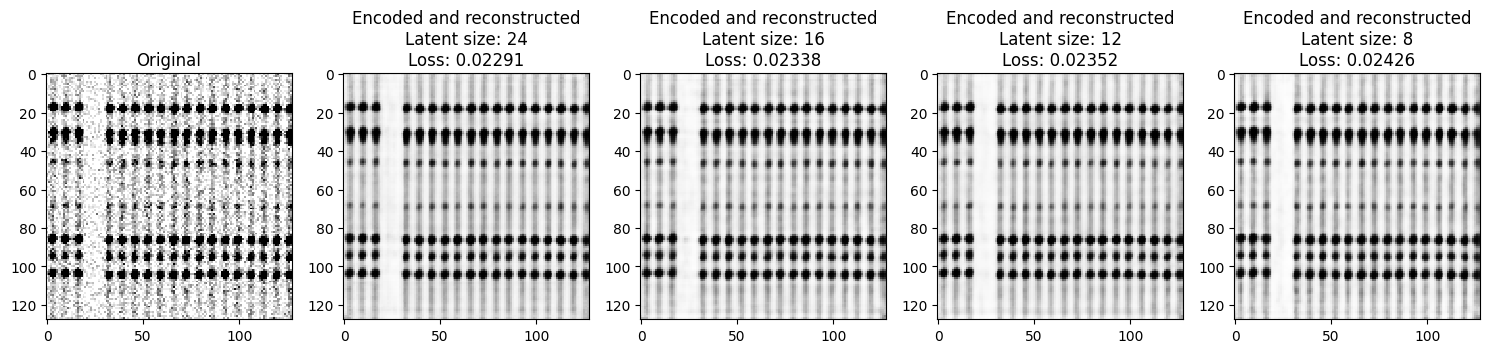

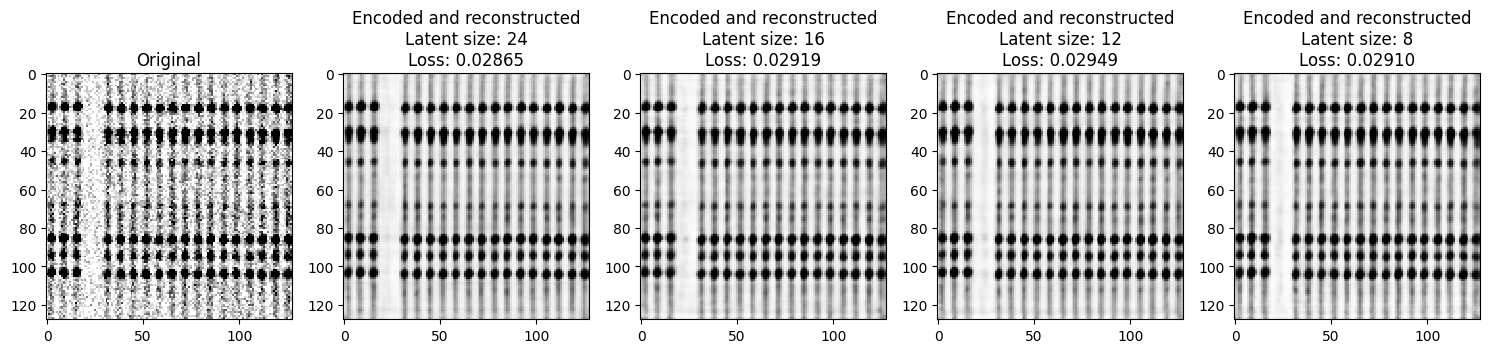

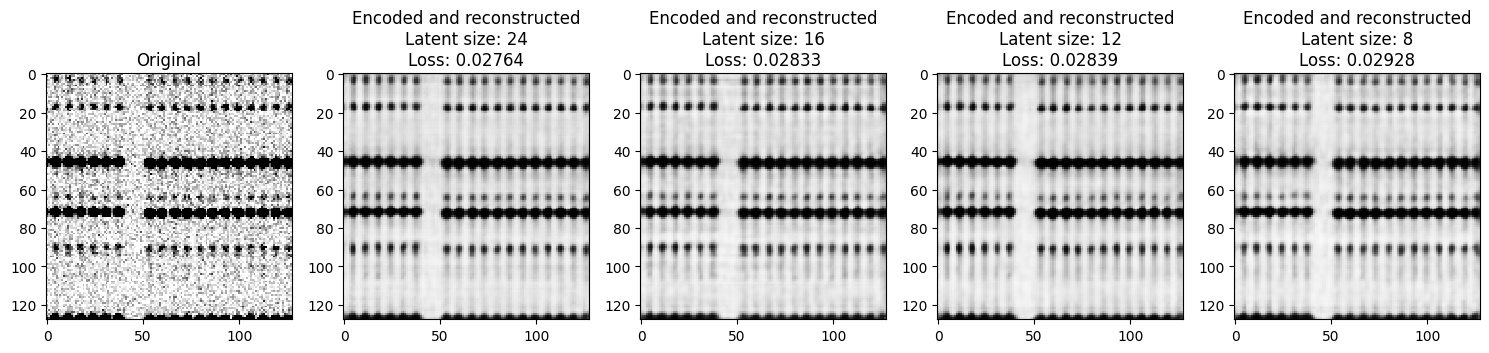

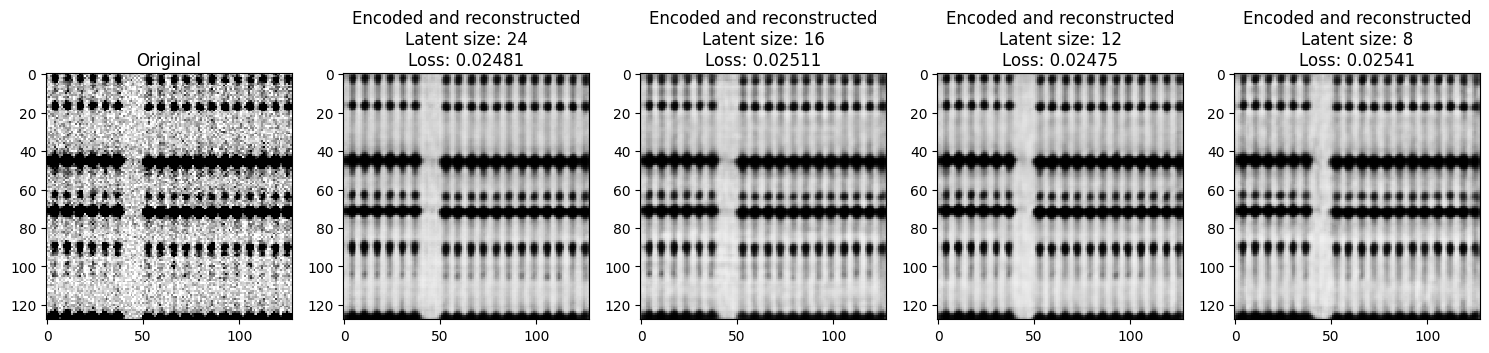

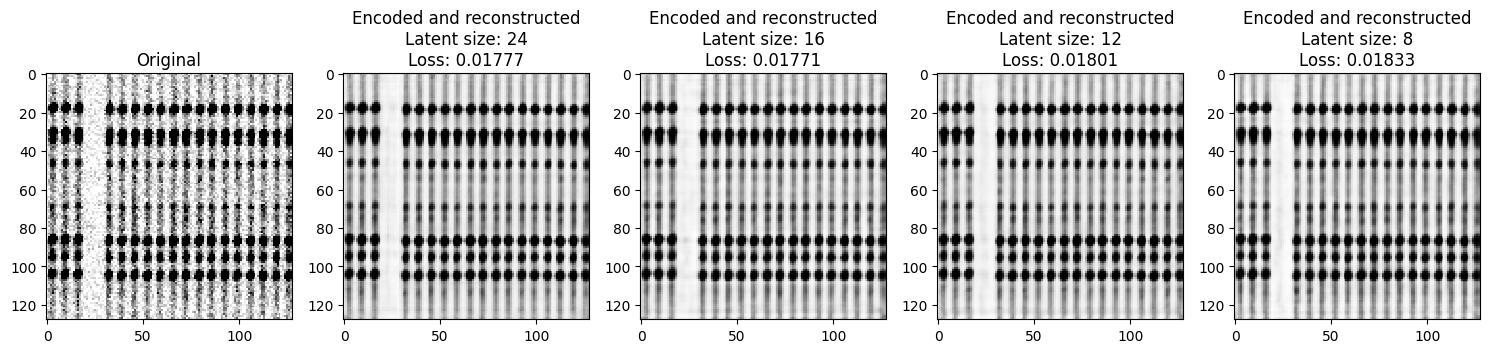

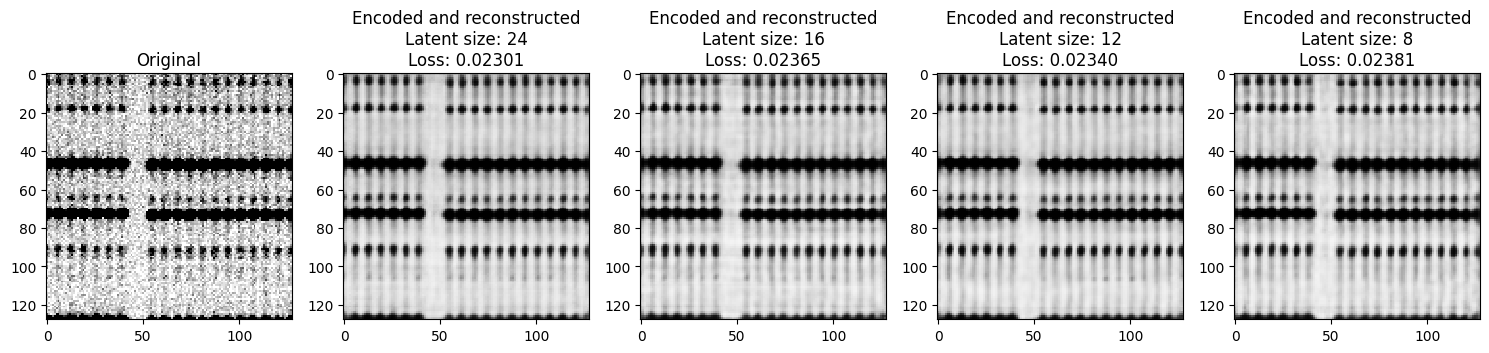

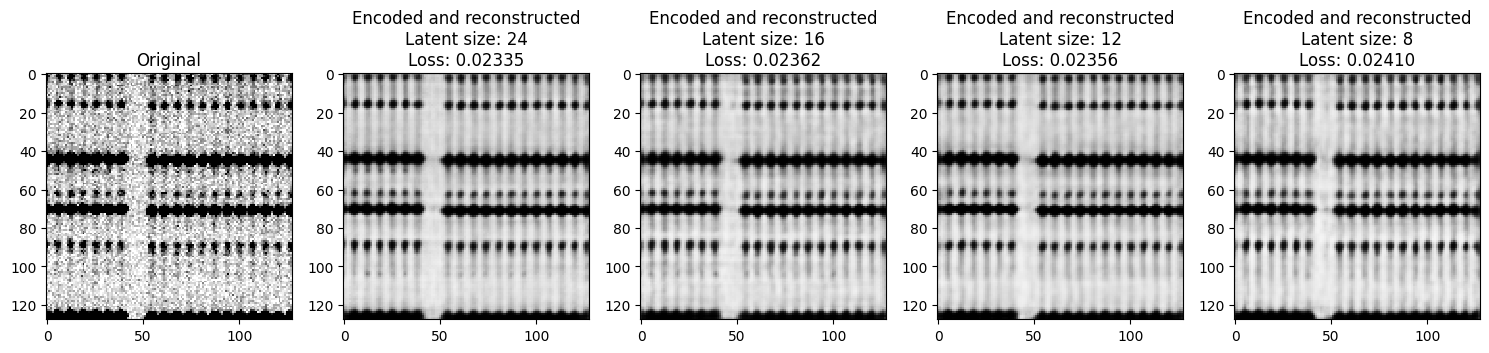

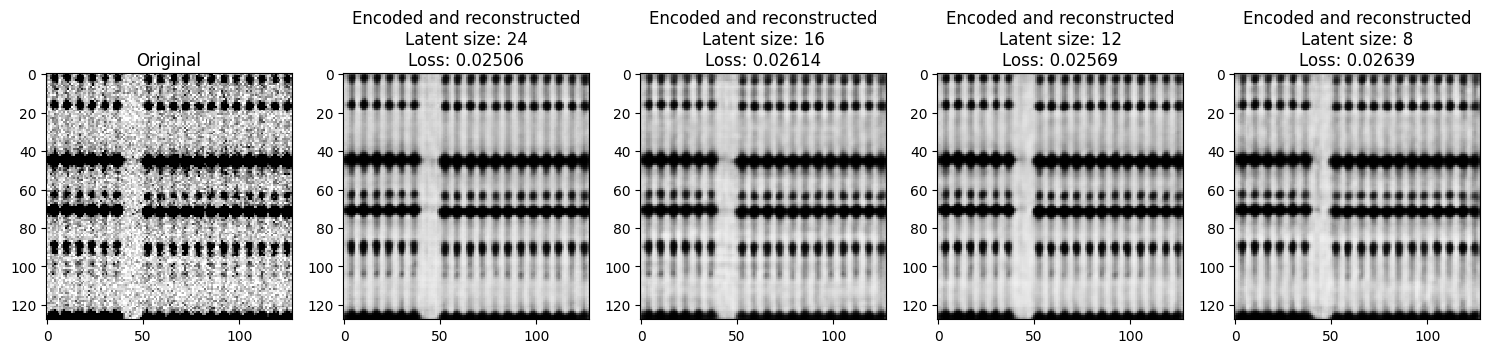

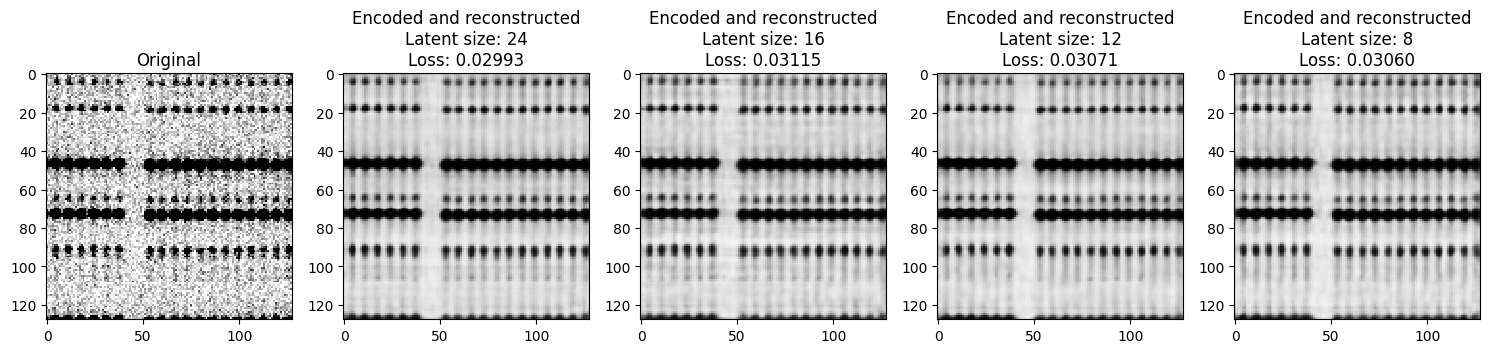

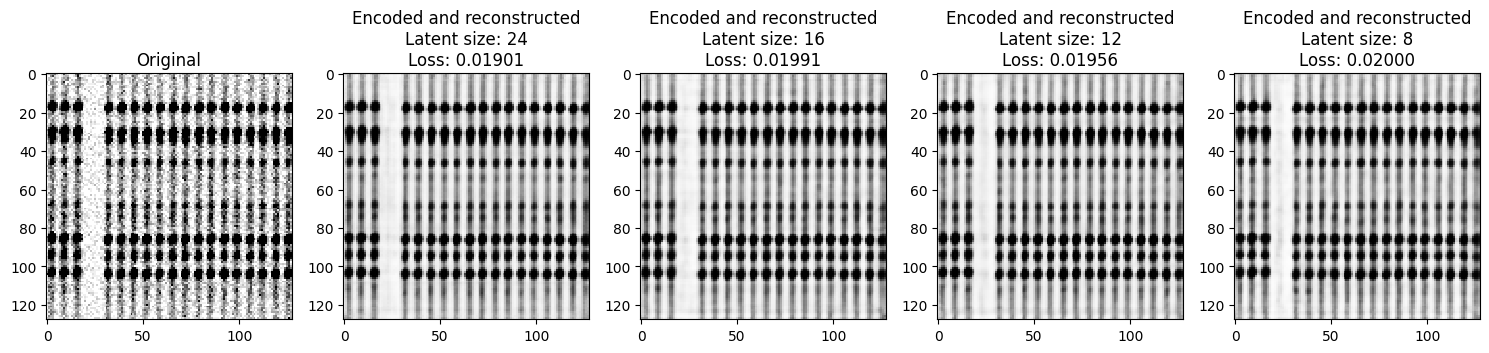

In [8]:
for img in te[:10]:
    kw = dict(cmap='binary', vmin=0, vmax=1, interpolation='nearest')
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
        
    axs[0].imshow(img.squeeze(), **kw)
    axs[0].set_title('Original')
    
    for i, latent in enumerate([24, 16, 12, 8]):
        x_hat = experiments[latent]['model'](img)
        axs[i+1].imshow(x_hat.squeeze(), **kw)
        axs[i+1].set_title(f'Encoded and reconstructed\nLatent size: {latent}\nLoss: {single_image_loss(x_hat, img):.5f}')
    fig.tight_layout()
    plt.show()

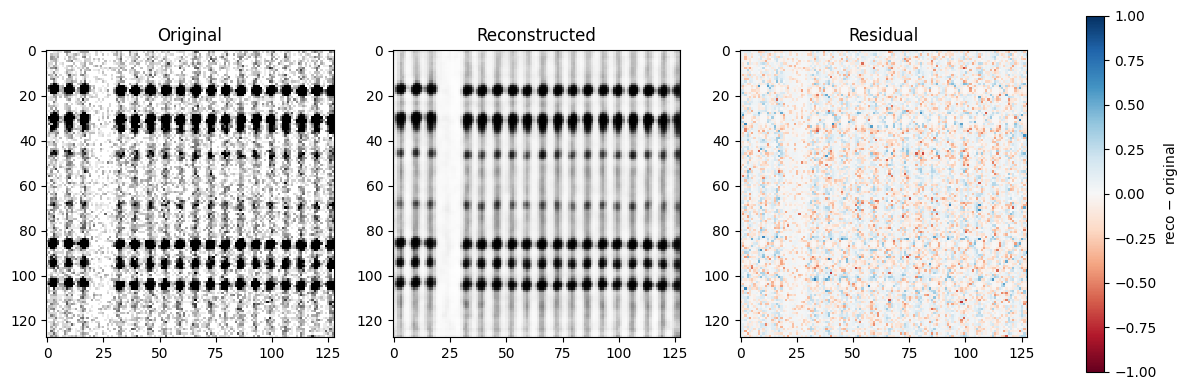

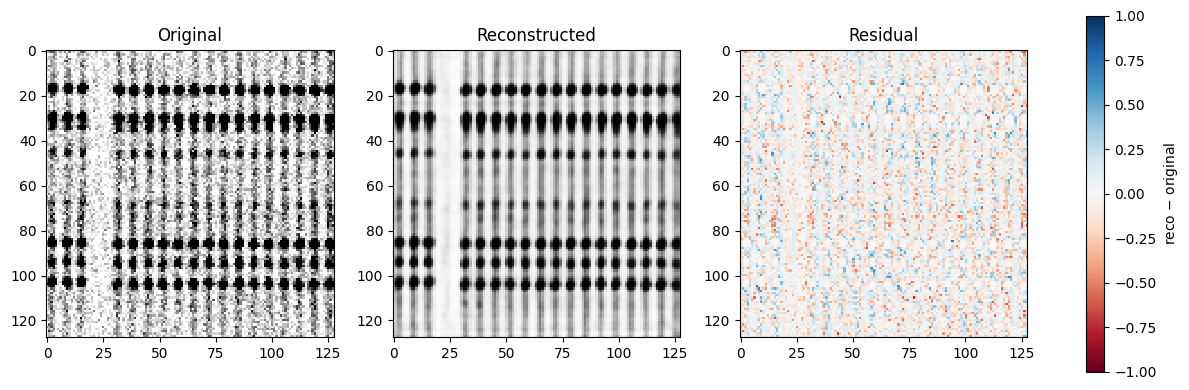

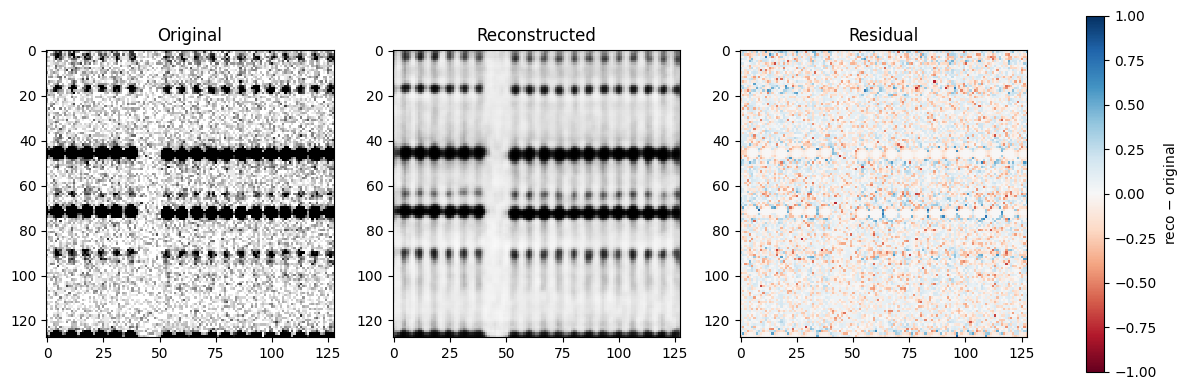

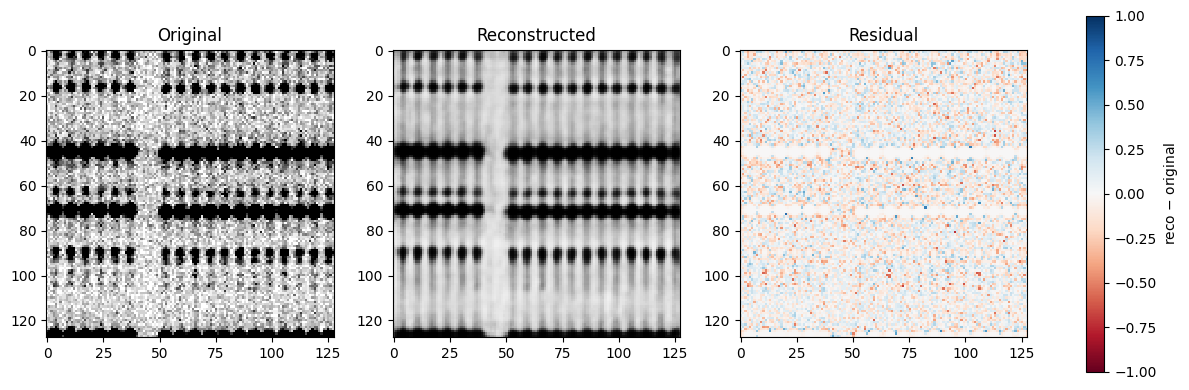

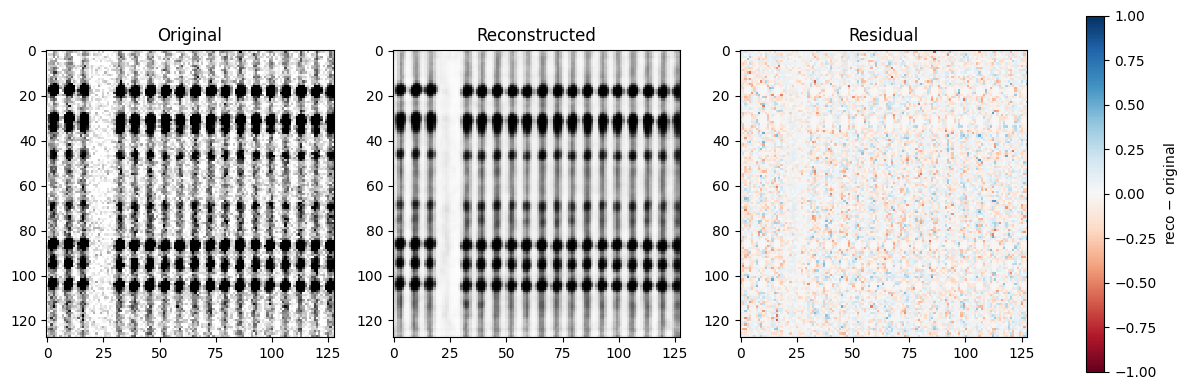

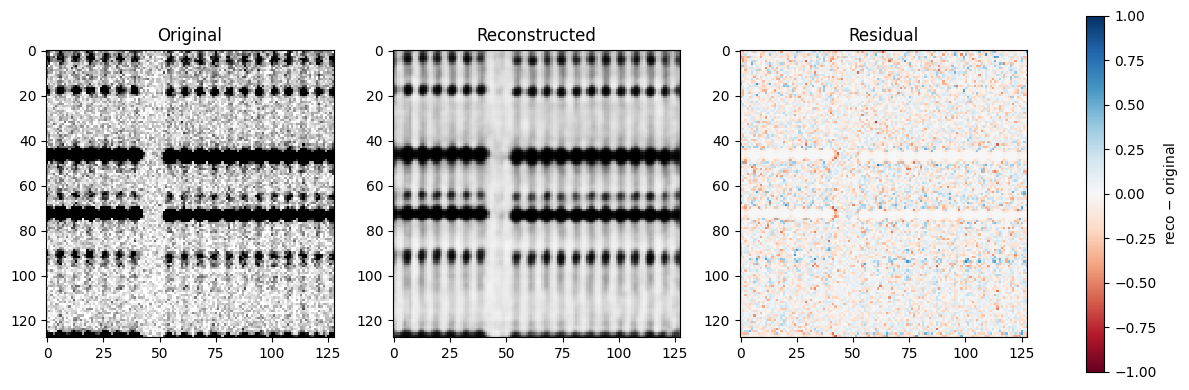

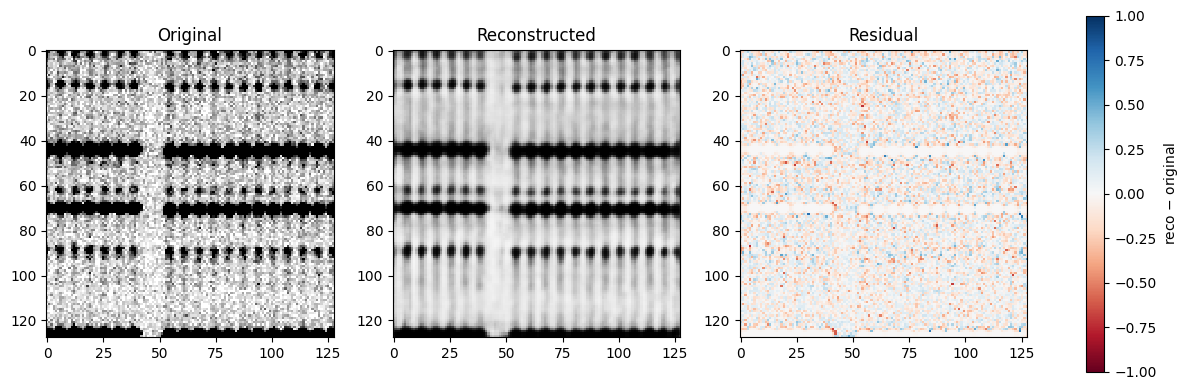

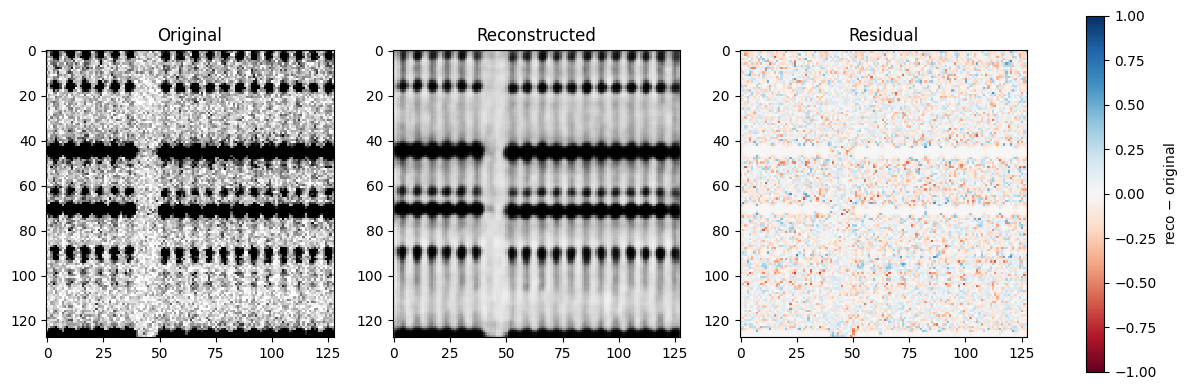

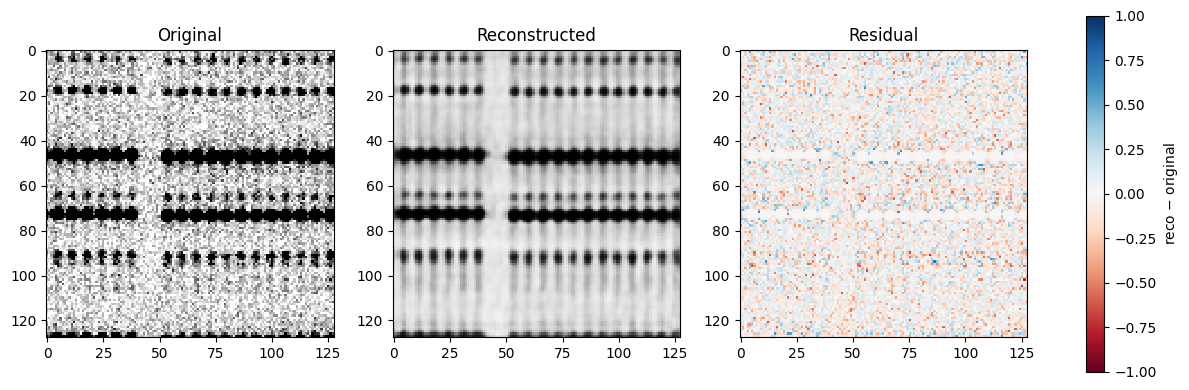

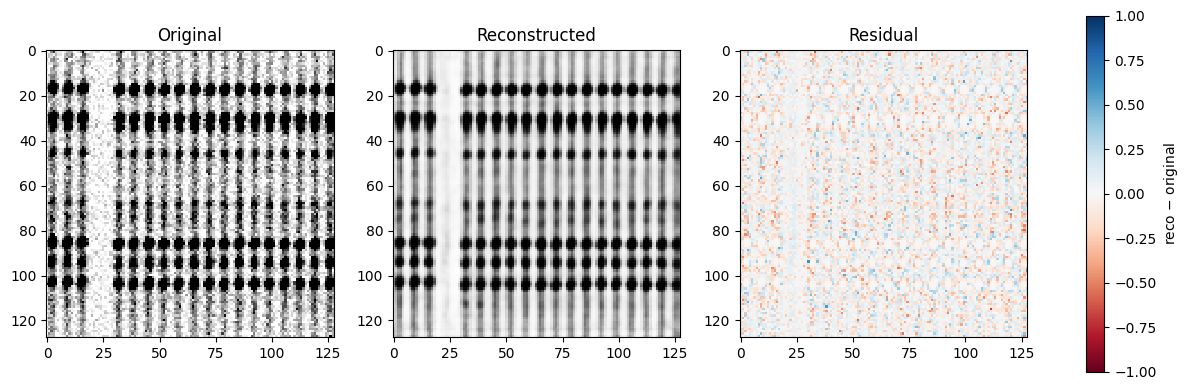

In [9]:
for img in te[:10]:
    kw = dict(cmap='binary', vmin=0, vmax=1, interpolation='nearest')
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw=dict(width_ratios=[8, 8, 8, 0.5]))
        
    axs[0].imshow(img.squeeze(), **kw)
    axs[0].set_title('Original')
    
    x_hat = experiments[8]['model'](img)
    axs[1].imshow(x_hat.squeeze(), **kw)
    axs[1].set_title('Reconstructed')
    
    im = axs[2].imshow((x_hat - img).squeeze(), cmap='RdBu', interpolation='nearest', vmin=-1, vmax=+1)
    axs[2].set_title('Residual')
    
    fig.colorbar(im, cax=axs[-1], label='reco $-$ original')

    fig.tight_layout()
    plt.show()